In [3]:
import tweepy
import sys
from importlib import reload
reload(sys)
import time
import math
from textblob import TextBlob
import json
import webcolors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

In [4]:
#Set database
conn = sqlite3.connect('twitter.db')
c = conn.cursor()
c.execute('''CREATE TABLE tweets
             (user_description, location, coordinates, text, user_name,user_created,
             user_followers, id, created, retweets_count
             ,user_blog_color, polarity, subjectivity)''')

In [28]:
consumer_key = 'N4bk4r0mAK5rWzcZYhiD0A4iD'
consumer_secret = 'WqNZq4dH9aO477KVxfOAoItGQFQvg49q0XhFH1Mu5ZnZU4TgSA'
access_token = '975790413935034368-sSw47cmjAED3Uz9wvWDpCRlt89rv5hX'
access_token_secret = 'GlY3vjF7eYyfnvwOapTbI6hDhhPrn7N4Gt8qoWSad2cyK'

# OAuth process, using the keys and tokens
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

# Creation of the actual interface, using authentication
api = tweepy.API(auth)

start_time = time.time()
limit = 1000
totalTweets = 0

In [29]:
class StreamListener(tweepy.StreamListener):

    def on_status(self, status):
        global positive
        global negative
        global totalTweets

        description = status.user.description
        loc = status.user.location
        text = status.text
        coords = status.coordinates
        name = status.user.screen_name
        user_created = status.user.created_at
        followers = status.user.followers_count
        id_str = status.id_str
        created = status.created_at
        retweets = status.retweet_count
        bg_color = status.user.profile_background_color


        if (time.time() - start_time) > limit:
            print(totalTweets)
            return False

        # print(status.user.location)
        # print(status.created_at)
        blob = TextBlob(text)
        sent = blob.sentiment

        polarity = sent.polarity
        subjectivity = sent.subjectivity
        totalTweets += 1
        
        if coords is not None:
            coords = json.dumps(coords)
        
        user_data = [(description,loc,coords,text,name,user_created,followers,id_str,
                      created,retweets,bg_color,polarity,subjectivity)]
            
        c.executemany('INSERT INTO tweets VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?)'
                      , user_data)



    def on_error(self, status_code):
        if status_code == 420:
            return False


In [30]:
stream_listener = StreamListener()
stream = tweepy.Stream(auth=api.auth, listener=stream_listener)

stream.sample()

59775


In [31]:
#followers and polarity
followers = []
followers_polarity = []
for val in c.execute('SELECT user_followers, polarity FROM tweets '):
    followers.append(int(val[0]))
    followers_polarity.append(float(val[1]))
followers_data = {"followers":followers, "polarity":followers_polarity}
followers_df = pd.DataFrame.from_dict(followers_data).sort_values(by=['followers'])

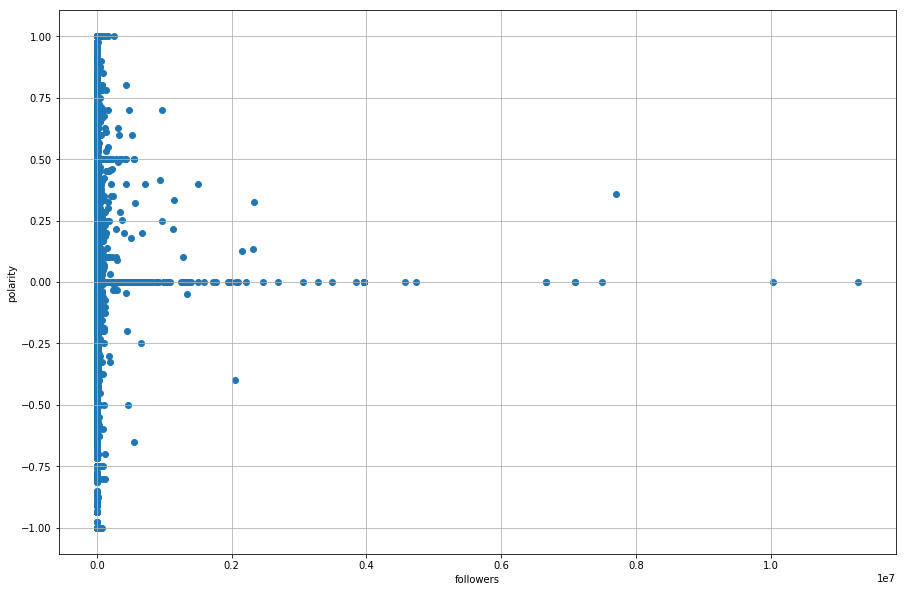

In [32]:
def plot(df, x, y, name):
    plt.figure(figsize=(15,10))
    plt.xlabel(x)
    plt.ylabel(y)
    plt.scatter(df[x], df[y])
    plt.grid()
    plt.plot()
    plt.savefig(name+".png")
    
plot(followers_df,"followers", "polarity","follower")

Oops, nothing significant. It seems like most people have followers less than 200 which totally makes sense. So how about we only observe the users who has followers less than 500 to see if there is anythig significant.

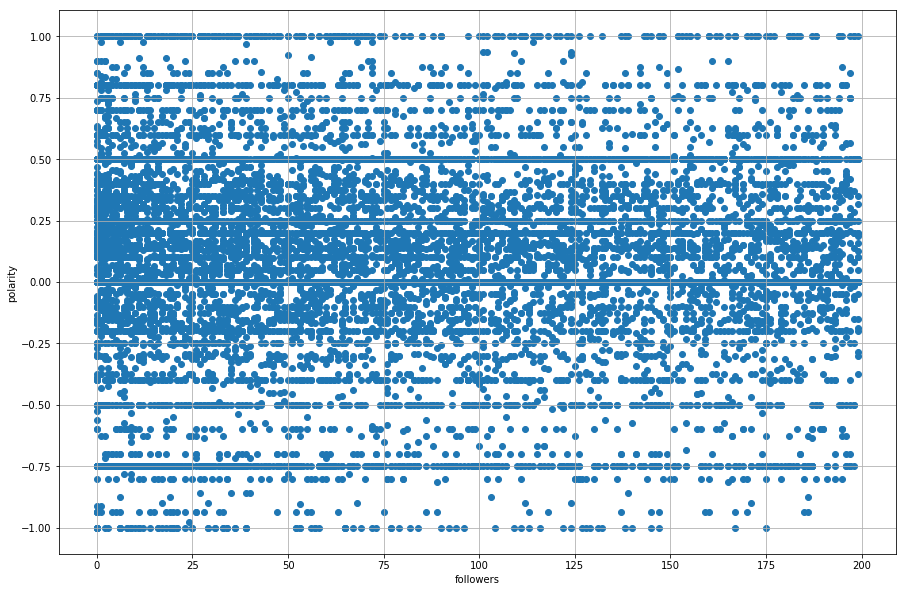

In [33]:
followers_df_lower = followers_df[followers_df['followers']<200]
plot(followers_df_lower, "followers", "polarity", "lower")

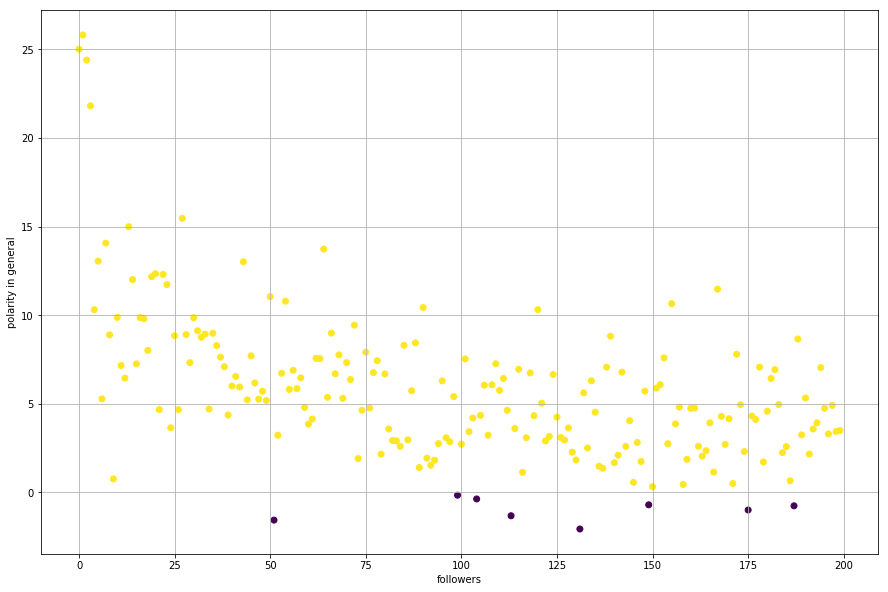

In [61]:
group_lower = followers_df_lower.groupby(['followers'],as_index=False).sum()
sign = []
for val in group_lower['polarity']:
    if val >=0:
        sign.append(1)
    else:
        sign.append(-1)
group_lower['sign'] = sign
plt.figure(figsize=(15,10))
plt.xlabel("followers")
plt.ylabel("polarity in general")
plt.grid()
plt.scatter(group_lower['followers'],group_lower['polarity'], c = group_lower['sign'])
plt.savefig("group_lower.png")

In [60]:
#background color and polarity
bg_color = []
polarity = []
def hex_to_decimal(char):
    '''
    
    Convert hex character to decimal number
    '''
    if ord(char) - (ord)('0') <=9:
        return ord(char) - (ord)('0')
    else:
        return 9 + (ord(char) - (ord)('A'))

#get user's background color to check if it is dark or light
for val in c.execute('SELECT user_blog_color, polarity FROM tweets '):
    hex_color = list(val[0])
    red = hex_to_decimal(hex_color[0]) * pow(16,1) 
        + hex_to_decimal(hex_color[1]) * pow(16,0)
    green = hex_to_decimal(hex_color[2]) * pow(16,1) 
        + hex_to_decimal(hex_color[3]) * pow(16,0)
    blue = hex_to_decimal(hex_color[4]) * pow(16,1) 
        + hex_to_decimal(hex_color[5]) * pow(16,0)
    #definition of luminance for digital formats
    darkness = 1-(0.299*red + 0.587*green + 0.114*blue)/255
    bg_color.append(darkness)
    polarity.append(float(val[1]))

color_data = pd.DataFrame({"color":bg_color,"polarity":polarity}) 
plot(color_data, "color", "polarity", "color")

IndentationError: unexpected indent (<ipython-input-60-00f4302c46e5>, line 18)

In [36]:
#Popular background color
color_dict = {}
for val in c.execute('SELECT user_blog_color FROM tweets '):
    if color_dict.get(val[0],0) == 0:
        color_dict[val[0]] = 1
    else :
        color_dict[val[0]] += 1

max_value = 0
color = ""
for val in color_dict:
    max_value = max(max_value, color_dict.get(val))
    color = val
print("The most popular background color is "+ color)

second_max = 0
second_color = ""
for val in color_dict:
    if val != color:
        second_max = max(second_max, color_dict.get(val))
        second_color = val
print("The second most popular background color is "+second_color)

third_max = 0
third_color = ""
for val in color_dict:
    if val != color and val != second_color:
        third_max = max(third_max, color_dict.get(val))
        third_color = val
print("The second most popular background color is "+third_color)

The most popular background color is FFDFBA
The second most popular background color is 8AC9D4
The second most popular background color is 9FA1D6


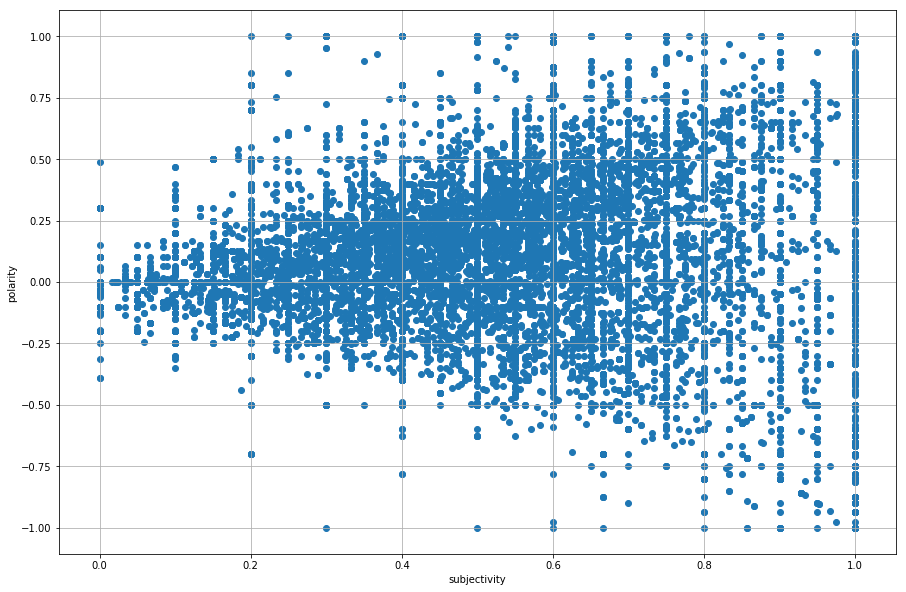

In [53]:
s = []
p = []
count = []
for val in c.execute('SELECT subjectivity, polarity FROM tweets'):
    s.append(float(val[0]))
    p.append(float(val[1]))

plt.figure(figsize=(15,10))
plt.xlabel("subjectivity")
plt.ylabel("polarity")
plt.scatter(s, p)
plt.grid()
plt.plot()
plt.savefig("ps"+".png")